<a href="https://colab.research.google.com/github/Nasser-Obeid/Transfer-Learning-implementation-with-ResNet-V2-50/blob/main/Transfer_Learning_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Todays project is about Transfer Learning using the ResNet architecture:
 Transfer learning is a very powerful tool to create new models to solve a specific problem with a model that is pre-trained to similar problem.
 So let's begin, with the "imports":


In [13]:
# importing the nessacary libraries
import zipfile
import os
import tensorflow as tf
import cv2 as cv
from tensorflow import keras
# The ImageDataGenerator is used to quickly convert the whole dataset into a set of tensors
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Tensorflow_hub is used to import the ResNet V2 50 model
import tensorflow_hub as hub

In [14]:
# Data set image binary classification problem of cats and dogs
# Extracting the dataset file
zip_ref = zipfile.ZipFile('/content/archive (1).zip')
zip_ref.extractall()
zip_ref.close()

Intializing the training dataset and testing dataset:

In [15]:
# Intializing constant for the size of the images and the batch size of training hyper parameters
IMAGE_SHAPE = (150, 150)
BATCH_SIZE = 16

# Directories for the testing data and training data
train_dir = "/content/train"
test_dir = "/content/test"

# Generating image dataset
train_data_gen = ImageDataGenerator(rescale = 1/255.,
                                    # Data augmentation
                                    zoom_range = 0.1,
                                    horizontal_flip = True)
# Generating image dataset
test_data_gen = ImageDataGenerator(rescale = 1/255.,
                                   # Data augmentation
                                   zoom_range = 0.1,
                                   horizontal_flip = True)


print("training dataset:")
train_data = train_data_gen.flow_from_directory(train_dir,
                                                target_size = IMAGE_SHAPE,
                                                batch_size = BATCH_SIZE,
                                                class_mode = "binary")
print("test dataset:")
test_data = test_data_gen.flow_from_directory(test_dir,
                                               target_size = IMAGE_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = "binary")

training dataset:
Found 557 images belonging to 2 classes.
test dataset:
Found 140 images belonging to 2 classes.


In [52]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

model = tf.keras.Sequential([
    hub.KerasLayer(# ResNet V2 50 model trained on ImageNet
                   resnet_url,
                   # Freezing layer and keeping the weights
                   trainable=False,
                    # Adding dimension to the inputs shape
                   input_shape = IMAGE_SHAPE + (3,)),
    # Top layer
    tf.keras.layers.Dense(250, name = "Added_layer_1", activation = "relu"),
    tf.keras.layers.Dense(250, name = "Added_layer_2", activation = "relu"),
    tf.keras.layers.Dense(100, name = "Added_layer_3", activation = "relu"),
    tf.keras.layers.Dense(50, name = "Added_layer_4", activation = "relu"),
    # Output layer is one node because this is a binary classification model
    tf.keras.layers.Dense(1, name = "Output_layer", activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 Added_layer_1 (Dense)       (None, 250)               512250    
                                                                 
 Added_layer_2 (Dense)       (None, 250)               62750     
                                                                 
 Added_layer_3 (Dense)       (None, 100)               25100     
                                                                 
 Added_layer_4 (Dense)       (None, 50)                5050      
                                                                 
 Output_layer (Dense)        (None, 1)                 51        
                                                                 
Total params: 24170001 (92.20 MB)
Trainable params: 60

# ResNet is a powerful CNN architecture.


*   Has over 20 million parameters (pre-trained with their wieghts and biases).
*   Generalizes very well on the ImageNet test.
*   Has a 1000 classes that it can identify.



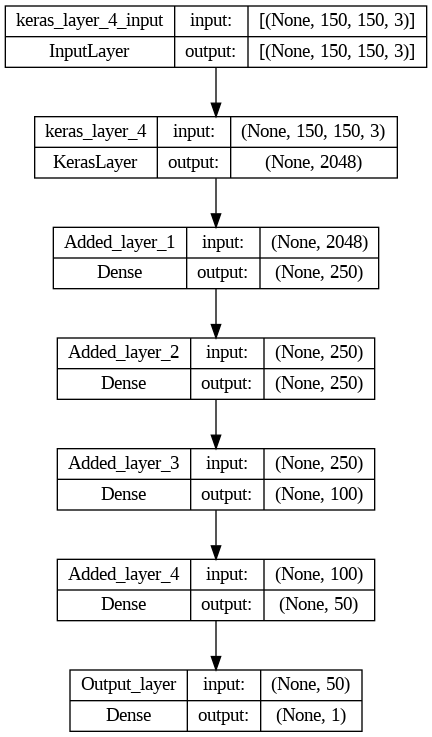

In [53]:
# A graph showing the functionality of the we designed
from tensorflow.keras.utils import plot_model

plot_model(model = model, show_shapes = True)

Our added layers will be the trained layers(we won't apply training on the frozen layers), and hopefully the model performs well.

In [54]:
model.compile(# Compiling the model
              loss = "BinaryCrossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              # Using the binary cross entropy loss function and the Adam optimizer
              metrics = "accuracy")

# About the Binary Cross Entropy loss function and the Adam optimizer:

* Binary cross entropy (also known as logarithmic loss or log loss) is a model metric that tracks incorrect labeling of the data class by a model, penalizing the model if deviations in probability occur into classifying the labels. Low log loss values equate to high accuracy values.
* Adam optimizer, short for Adaptive Moment Estimation optimizer, is an optimization algorithm commonly used in deep learning. It is an extension of the stochastic gradient descent (SGD) algorithm and is designed to update the weights of a neural network during training.

In [55]:
model.fit(# Fitting the model
          train_data,
          # The batch size of trained dataset
          batch_size = BATCH_SIZE,
          # Number of iterations
          epochs = 15,
          validation_data = test_data,
          validation_batch_size = BATCH_SIZE,
          # Early stopping when the loss gets no improvement
          callbacks = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 1, min_delta = 0.01))

Epoch 1/15
35/35 [==============================] - 75s 2s/step - loss: 0.3286 - accuracy: 0.8600 - val_loss: 0.2531 - val_accuracy: 0.8500
Epoch 2/15
35/35 [==============================] - 69s 2s/step - loss: 0.1053 - accuracy: 0.9623 - val_loss: 0.2158 - val_accuracy: 0.9214
Epoch 3/15
35/35 [==============================] - 73s 2s/step - loss: 0.0696 - accuracy: 0.9767 - val_loss: 0.2348 - val_accuracy: 0.9071
Epoch 4/15
35/35 [==============================] - 69s 2s/step - loss: 0.0461 - accuracy: 0.9785 - val_loss: 0.6831 - val_accuracy: 0.8357
Epoch 5/15
35/35 [==============================] - 69s 2s/step - loss: 0.0684 - accuracy: 0.9713 - val_loss: 0.1738 - val_accuracy: 0.9214


Notice that we stopped at the 5th epoch (iteration) before reaching the final iteration, the reason behind this is that we reached the desired loss value after the fifth iteration, and based on that, the algorithm determined to stop the training.

In [57]:
# Saving the model
model.save('Transfer_model_save')

# Evaluation and prediction:

> The most important step, Here we determine if the model is useful for our use case(hopefully it's useful).


In [58]:
model.evaluate(test_data)

9/9 [==============================] - 12s 1s/step - loss: 0.2121 - accuracy: 0.9214


[0.21209150552749634, 0.9214285612106323]

Excellent, the model reached an accuracy of %92.14 and loss factor of 0.225, now that we determined our function is
useable for our use case let's use it for classification.

In [59]:
 # Predicting using the test data list
 model.predict(test_data)

9/9 [==============================] - 14s 1s/step


array([[2.97858655e-01],
       [1.32235427e-05],
       [9.99989927e-01],
       [1.53820565e-06],
       [9.99930024e-01],
       [9.97221291e-01],
       [4.76433030e-07],
       [5.27936709e-06],
       [3.30127659e-03],
       [9.99909043e-01],
       [1.98558392e-03],
       [9.99998748e-01],
       [9.99867678e-01],
       [9.99971330e-01],
       [9.99998152e-01],
       [9.99999762e-01],
       [2.50160247e-01],
       [9.76072311e-01],
       [3.03598263e-05],
       [2.69848943e-01],
       [5.99392979e-06],
       [2.38997508e-02],
       [1.82753541e-02],
       [9.99736667e-01],
       [1.40343839e-03],
       [3.96124661e-01],
       [7.87564591e-02],
       [9.79703844e-01],
       [9.96436357e-01],
       [2.73190090e-04],
       [5.90333220e-05],
       [1.28410044e-04],
       [9.99242485e-01],
       [9.91802573e-01],
       [9.99974966e-01],
       [9.99409914e-01],
       [9.99925137e-01],
       [9.99999881e-01],
       [9.99915838e-01],
       [9.99614120e-01],


In [60]:
# Prediction on single images
cat = cv.imread('/content/2560px-A-Cat.jpg')
# Making sure the size of images is the same as the dataset size
cat = cv.resize(cat, dsize= IMAGE_SHAPE, interpolation = cv.INTER_AREA)

# Turning the images in tensors to utilize the power of Googles TPUs
cat = tf.constant(cat)
cat = tf.expand_dims(cat, axis = 0)/255

dog = cv.imread('/content/Dog_Breeds.jpg')
dog = cv.resize(dog, dsize= IMAGE_SHAPE, interpolation = cv.INTER_AREA)

dog = tf.constant(dog)
dog = tf.expand_dims(dog, axis = 0)/255
cat.shape, dog.shape

(TensorShape([1, 150, 150, 3]), TensorShape([1, 150, 150, 3]))

In [61]:
model.predict(cat), model.predict(dog)

1/1 [==============================] - 0s 125ms/step


(array([[6.6263046e-06]], dtype=float32), array([[0.99998164]], dtype=float32))

As we can see it returned a tensor full of arrays, the
closer an index is to 0 then it is classified as class [0] which is in this case class cats, and if an index had a percentage close to 1 then the model classifies it as class [1] which is dogs.

# In conclusion:

Transfer learning helps us complete tasks using the leverage of a sophisticated, more powerful pre-trained model while maintaining a generalized output and less error when training the new model.